In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Load data
### Read group data

Depending on the analysis, we require data from all groups, for example to compare psychometrics, or only from the groups where there was no technical error, in order to study trajectories and emergence values as well as psychometrics.

In [2]:
groups_df = pd.read_csv(f"../experiment/groups_data.csv").set_index('Group')
groups_df = groups_df.drop(['Start', 'End', 'Notes'], axis = 1)

In [3]:
groups_df_noerr = groups_df[groups_df.Error == 0 ].drop(['Error', 'Filt_buffer'], axis = 1)

To perform ANOVA we need to group the game outcomes in 3 groups: true emergence, i.e. `Emerged=1` and `Manual=0` (`2`), false emergence i.e. `Emerged=0` and `Manual=1` (`1`), no emergence i.e. `Emerged=0` and `Manual=0` (`0`).

In [4]:
def game_outcome(row):
    if row.Manual == 0:
        if row.Emerged == 1:
            return 2
        else:
            return 0
    elif row.Manual == 1:
        if row.Emerged == 0:
            return 1

In [5]:
groups_df['Outcome']       = groups_df.apply(game_outcome, axis = 1)
groups_df_noerr['Outcome'] = groups_df_noerr.apply(game_outcome, axis = 1)

In [6]:
groups_df

,Duration,Manual,Emerged,Filt_buffer,Error,Outcome
Group,,,,,,
A_1,918,0,1,36,1,2
A_2,2918,1,0,36,0,1
A_3,575,0,1,36,0,2
A_4,794,0,1,36,0,2
A_5,2204,1,0,60,0,1
A_6,2348,0,1,60,0,2
A_7,173,1,0,60,1,1
A_8,3753,0,0,60,0,0
A_9,4141,0,0,60,0,0


In [7]:
groups_df_noerr

,Duration,Manual,Emerged,Outcome
Group,,,,
A_2,2918,1,0,1
A_3,575,0,1,2
A_4,794,0,1,2
A_5,2204,1,0,1
A_6,2348,0,1,2
A_8,3753,0,0,0
A_9,4141,0,0,0
B_1,2524,0,1,2
B_2,1072,0,0,0


### Read trajectory emergence
We read the values of emergence $\Psi$ during the gameplay, and add statistics to the group data. We only use data from groups where there was **no error** encountered in the tech, since the emergence values would otherwise not be meaningful.

We need to use the `Filt_buffer` and `Duration`, to find the relevant segment of gameplay. After that is done, we also update the `Duration` to store exactly the number of frames we averaged over.

In [8]:
FRAMERATE = 12
START_THRESHOLD = FRAMERATE * 15

In [9]:
psi, pstats = {}, {}
for g in groups_df_noerr.index:
    start  = int(groups_df.Filt_buffer[g] / 3 * 2 + START_THRESHOLD)
    length =  int(groups_df.Duration[g]) - start + 1

    if os.path.exists(f"psi/{g}-psi.csv"):
        psis = pd.read_csv(f"psi/{g}-psi.csv")
        psis = psis[psis.type == 'Filtered']
        psis = psis[psis.frame >= start]
        psis = psis[psis.frame < start + length]
        psi[g] = np.array(psis.psi)
        pstats[g] = {
            'Psi_max' : psi[g].max(),
            'Psi_min' : psi[g].min(),
            'Psi_avg' : psi[g].mean(),
            'Psi_var' : psi[g].var()
        }

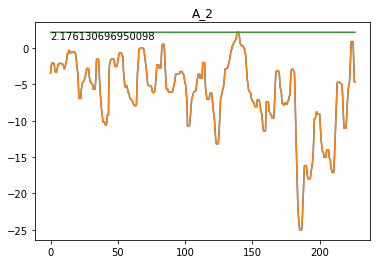

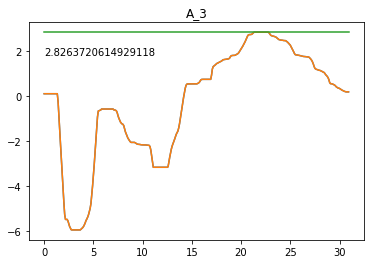

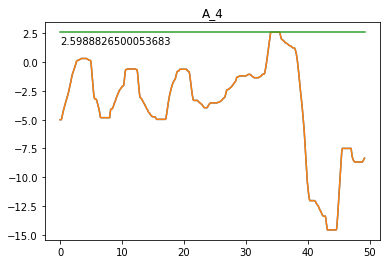

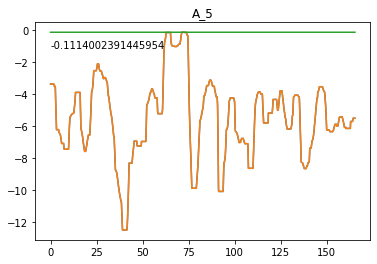

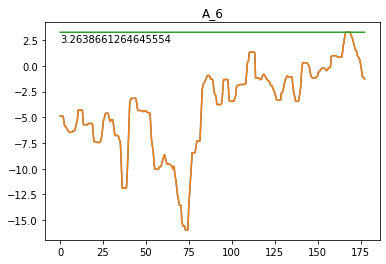

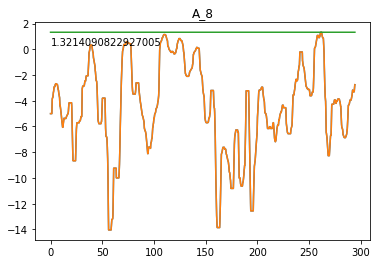

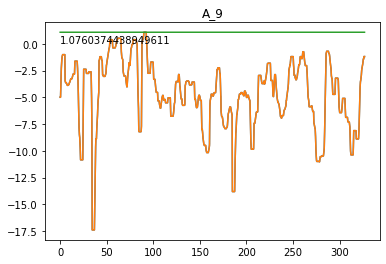

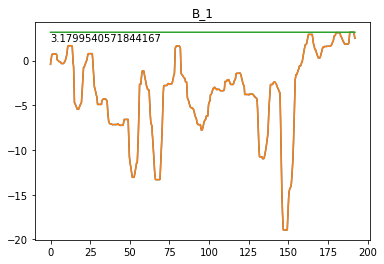

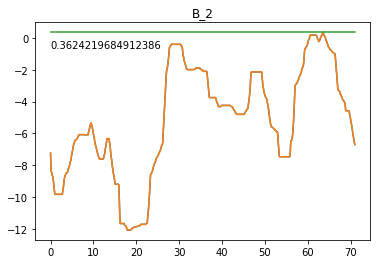

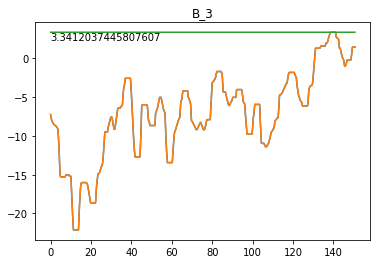

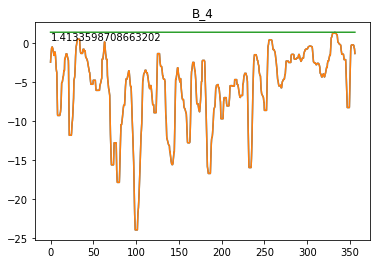

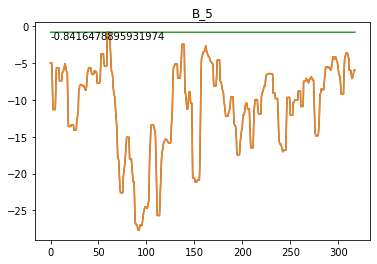

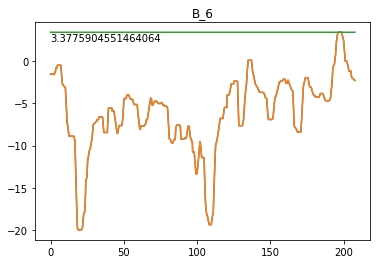

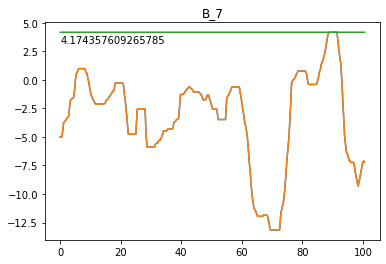

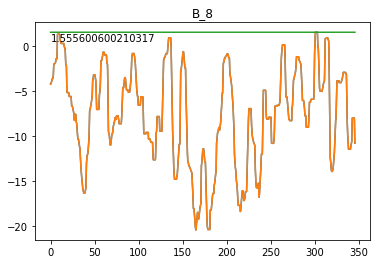

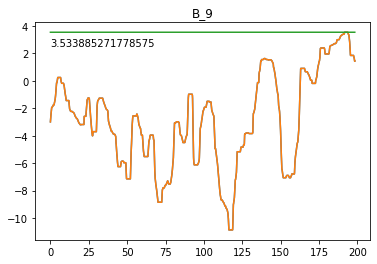

In [10]:
for g in psi.keys():
    plt.plot(np.arange(0, len(psi[g])) / FRAMERATE, psi[g])
    m = max(psi[g])
    l = len(psi[g])
    plt.plot(np.arange(0, l) / FRAMERATE, psi[g])
    plt.plot(np.arange(0, l) / FRAMERATE, [ m ] * l)
    plt.annotate(m, (0, m - 1))
    plt.title(g)
    plt.show()


### Read order parameter data
Instantaneous order parameters have been precomputed for the trajectories in the game play at each individual game state, 12 times per second. We load this data into a dataframe.

Again, we only use data from groups where there was **no error** encountered in the tech, since otherwise the trajectories or their order parameters are either not available or incorrect.

In [11]:
ordp_names = [ 'mean_dist_cmass', 'var_dist_cmass', 
              'mean_dist_nearest', 'var_angle', 'vicsek_order']

In [12]:
ordp_dfs = {}

for g in groups_df.index:  
    ordp_d = {}
    for p in ordp_names:
        if os.path.exists(f"flocking/{g}/{p}.txt"):
            op = np.loadtxt(f"flocking/{g}/{p}.txt")
            ind = list(range(len(op)))
            ordp_d[p] = op

    if len(ordp_d.keys()):
        ordp_dfs[g] = pd.DataFrame.from_dict(ordp_d, orient = 'index').transpose()

In [13]:
ordp_dfs[groups_df_noerr.index[0]].head()

,mean_dist_cmass,var_dist_cmass,mean_dist_nearest,var_angle,vicsek_order
0,0.348296,0.013304,0.218285,1.219825,0.519844
1,0.342268,0.012932,0.215836,1.920663,0.703946
2,0.361091,0.022434,0.236474,2.195336,0.530676
3,0.330975,0.012082,0.207604,2.866272,0.450739
4,0.329147,0.011792,0.204257,2.401698,0.459896


### Read player questionnaire data
Each player gave questionnaire responses before and after the game. These have been aggregated per-player.

In [15]:
player_df = pd.read_csv('../subj-data/quest/SL_GERF_player_questionnaire.csv')

In [16]:
player_df.head()

,Player,Group,DavisPerspective,WattsSelf,WattsOthers,WattsWorld,WattsTotal
0,A1.1,A_1,3.142857,80.000000,39.166667,63.571429,60.912698
1,A1.2,A_1,3.571429,50.000000,26.500000,48.000000,41.500000
2,A1.4,A_1,3.428571,54.166667,79.166667,50.000000,61.111111
3,A1.5,A_1,4.142857,53.333333,70.000000,82.857143,68.730159
4,A1.6,A_1,3.428571,99.000000,62.500000,0.428571,53.976190


In [17]:
player_df.dropna().Player.count()

135

In [18]:
print(len(player_df.dropna().Group.unique()))

19


# Per-player data

Since we have collected questionnaire data from all groups, regardless of the success or failure of the experimental hardware, we can make use of this data in analysis. The groups experiencing technological issues have been given the game reward without winning the game, so they can be included in the category `emerged = 0`, `manual = 1`.

We gather together averages during the gameplay in each group, with questionnaire responses. Each player will have a **single entry** with their questionnaire reponse, joined with their group's performance in the game. 

Note the duration is in frames, so we divide by FPS (in our case 12) to obtain gameplay duration in seconds.


In [22]:
df_player = player_df.join(groups_df, on='Group', how='right')
df_player = df_player.drop([ 'Filt_buffer', 'Error' ], axis = 1).set_index(['Player'])
df_player.head()

,Group,DavisPerspective,WattsSelf,WattsOthers,WattsWorld,WattsTotal,Duration,Manual,Emerged,Outcome
Player,,,,,,,,,,
A1.1,A_1,3.142857,80.000000,39.166667,63.571429,60.912698,918,0,1,2
A1.2,A_1,3.571429,50.000000,26.500000,48.000000,41.500000,918,0,1,2
A1.4,A_1,3.428571,54.166667,79.166667,50.000000,61.111111,918,0,1,2
A1.5,A_1,4.142857,53.333333,70.000000,82.857143,68.730159,918,0,1,2
A1.6,A_1,3.428571,99.000000,62.500000,0.428571,53.976190,918,0,1,2


We also combine the data from the groups which did not error with the average statistics for emergence.

In [23]:
df_player_group_psi = df_player.join(pd.DataFrame(pstats).T, on='Group', how='outer')
df_player_group_psi.Duration /= FRAMERATE

In [24]:
df_player_group_psi.head()

,Group,DavisPerspective,WattsSelf,WattsOthers,WattsWorld,WattsTotal,Duration,Manual,Emerged,Outcome,Psi_max,Psi_min,Psi_avg,Psi_var
Player,,,,,,,,,,,,,,
A1.1,A_1,3.142857,80.000000,39.166667,63.571429,60.912698,76.5,0,1,2,NaN,NaN,NaN,NaN
A1.2,A_1,3.571429,50.000000,26.500000,48.000000,41.500000,76.5,0,1,2,NaN,NaN,NaN,NaN
A1.4,A_1,3.428571,54.166667,79.166667,50.000000,61.111111,76.5,0,1,2,NaN,NaN,NaN,NaN
A1.5,A_1,4.142857,53.333333,70.000000,82.857143,68.730159,76.5,0,1,2,NaN,NaN,NaN,NaN
A1.6,A_1,3.428571,99.000000,62.500000,0.428571,53.976190,76.5,0,1,2,NaN,NaN,NaN,NaN


In [25]:
df_player_group_psi.to_csv('GERF_group_player_data.csv')

In [26]:
print(len(df_player_group_psi.index))
print(len(df_player_group_psi.Group.unique()))

136
20


In [27]:
print(len(df_player_group_psi[df_player_group_psi.Manual == 1].index))
print(len(df_player_group_psi[df_player_group_psi.Manual == 1].Group.unique()))

27
3


In [28]:
df_player_group_psi[df_player_group_psi.Emerged == 0]

,Group,DavisPerspective,WattsSelf,WattsOthers,WattsWorld,WattsTotal,Duration,Manual,Emerged,Outcome,Psi_max,Psi_min,Psi_avg,Psi_var
Player,,,,,,,,,,,,,,
A2.1,A_2,3.000000,80.000000,83.333333,50.000000,71.111111,243.166667,1,0,1,2.176131,-25.009764,-6.113833,25.614317
A2.2,A_2,3.000000,16.666667,78.333333,51.428571,48.809524,243.166667,1,0,1,2.176131,-25.009764,-6.113833,25.614317
A2.3,A_2,3.000000,3.333333,67.833333,1.857143,24.341270,243.166667,1,0,1,2.176131,-25.009764,-6.113833,25.614317
A2.4,A_2,2.857143,26.666667,82.500000,54.285714,54.484127,243.166667,1,0,1,2.176131,-25.009764,-6.113833,25.614317
A2.5,A_2,2.857143,69.166667,69.166667,66.428571,68.253968,243.166667,1,0,1,2.176131,-25.009764,-6.113833,25.614317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B8.4,B_8,3.571429,56.666667,71.666667,75.714286,68.015873,364.000000,0,0,0,1.555601,-20.433607,-7.661335,29.084164
B8.5,B_8,2.642857,48.333333,66.666667,71.428571,62.142857,364.000000,0,0,0,1.555601,-20.433607,-7.661335,29.084164
B8.6,B_8,3.000000,8.333333,58.333333,8.571429,25.079365,364.000000,0,0,0,1.555601,-20.433607,-7.661335,29.084164


In [29]:
print(len(df_player_group_psi[df_player_group_psi.Emerged == 0].index))
print(len(df_player_group_psi[df_player_group_psi.Emerged == 0].Group.unique()))

65
9


In [30]:
print(len(df_player_group_psi[df_player_group_psi.Emerged == 1].index))
print(len(df_player_group_psi[df_player_group_psi.Emerged == 1].Group.unique()))

71
11


In [31]:
print(len(df_player_group_psi.dropna().index))
print(len(df_player_group_psi.dropna().Group.unique()))

112
16


# Repeated-measures game data (segmented)

For a more detailed analysis of the emergent behaviour, we study 10 second segments of the game data. We do so by computing averages and standard deviation of $\Psi$, as well as several instantaneous order parameters used in flocking literature, for each segment. 

In this analysis we will require video recordings for trajectories for all the games, so we must remove all groups that do not have video data, or where there have been any issues, such as a different way of computing emergence, or any errors occurred.

### Segment emergence values
The `psi` dictionary already contains the emergence value for each frame in the game, with the relevant sections of the game already trimmed. We obtain statistics for each 10s segment.

In [32]:
BLOCK_LEN_SEC = 10
BLOCK_LEN_FRAMES = FRAMERATE * BLOCK_LEN_SEC

In [35]:
segment_psi = []

for g in groups_df_noerr.index:    
    length = groups_df_noerr.Duration[g]
    blocks, rem = divmod(length, BLOCK_LEN_FRAMES)  
    if rem <= 20:
        blocks -= 1
        
    for b in range(blocks):
        s = b * BLOCK_LEN_FRAMES
        e = s + BLOCK_LEN_FRAMES
        block_psi = psi[g][s: e]
        segment_psi.append({
            'Group':    g,
            'Segment':  b + 1,
            'mean_psi': np.mean(block_psi),
            'std_psi':  np.std( block_psi, ddof = 1)
        })

/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/lib/python3/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/lib/python3/dist-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/lib/python3/dist-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/usr/lib/python3/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [36]:
df_psi = pd.DataFrame(segment_psi)

In [37]:
df_psi.head()

,Group,Segment,mean_psi,std_psi
0,A_2,1,-2.446542,0.427370
1,A_2,2,-1.158518,0.841010
2,A_2,3,-4.559308,1.360282
3,A_2,4,-5.521123,2.743205
4,A_2,5,-4.628262,3.729847


### Segment order parameter data

Unlike the computation of $\Psi$, the order parameters have only been computed for the relevant segment of gameplay data, and moreover to allow the gameplay data to be split in 10s blocks. Thus there may be less frames with an instantaneous order order parameter computed than frames with an instantaneous emergence. Thus we do not remove any states at the beginning or end of the game, but only segment the data in 10s blocks.

In [41]:
segment_ordp = []

for g in ordp_dfs.keys():
    length = groups_df.Duration[g]
    blocks, rem = divmod(length, BLOCK_LEN_FRAMES)
    if rem <= 20:
        blocks -= 1        

    for b in range(blocks):
        s = b * BLOCK_LEN_FRAMES
        e = s + BLOCK_LEN_FRAMES

        segment = { 'Group': g, 'Segment': b + 1 }    
        for p in ordp_names:
            block_ordp = ordp_dfs[g][p][s: e]
            segment[f"{p}"]      = np.nanmean(block_ordp)
            segment[f"err_{p}"]  = np.nanstd( block_ordp, ddof = 1)
            
        segment_ordp.append(segment)

<ipython-input-41-7382905bcbda>:16: RuntimeWarning: Mean of empty slice
  segment[f"{p}"]      = np.nanmean(block_ordp)


In [42]:
df_ordp = pd.DataFrame(segment_ordp).dropna()

In [43]:
df_ordp.head()

,Group,Segment,mean_dist_cmass,err_mean_dist_cmass,var_dist_cmass,err_var_dist_cmass,mean_dist_nearest,err_mean_dist_nearest,var_angle,err_var_angle,vicsek_order,err_vicsek_order
0,A_2,1,0.221130,0.042343,0.007484,0.002287,0.145433,0.021489,6.275370,3.735643,0.270781,0.140430
1,A_2,2,0.186737,0.007012,0.003961,0.000756,0.121680,0.009017,3.914421,2.548290,0.217356,0.100903
2,A_2,3,0.182254,0.005901,0.002459,0.000829,0.106969,0.007449,4.949723,3.143203,0.185249,0.075569
3,A_2,4,0.163953,0.014682,0.003229,0.002066,0.103224,0.012526,5.969588,3.772577,0.241680,0.109943
4,A_2,5,0.205667,0.016449,0.003812,0.001444,0.126370,0.011810,5.305103,3.592199,0.203395,0.092963


### Combine all segment data

We expect to obtain 316 valid segments to have the same data structuring as the Aesthetics data collection, see [experiment data on GitHub](https://github.com/Synch-Live/AestheticsFlask/blob/main/web/static/videos.csv).

In [44]:
df_segment = df_psi.join(df_ordp.set_index(['Group', 'Segment']),
                         on=['Group', 'Segment'], how='inner').set_index(['Group', 'Segment'])

In [45]:
df_segment

mean_psi   std_psi  mean_dist_cmass  err_mean_dist_cmass  \
Group Segment                                                             
A_2   1       -2.446542  0.427370         0.221130             0.042343   
      2       -1.158518  0.841010         0.186737             0.007012   
      3       -4.559308  1.360282         0.182254             0.005901   
      4       -5.521123  2.743205         0.163953             0.014682   
      5       -4.628262  3.729847         0.205667             0.016449   
...                 ...       ...              ...                  ...   
B_9   15       0.422074  1.445226         0.273335             0.068898   
      16      -6.668520  0.630716         0.367245             0.007310   
      17      -0.547172  2.059900         0.318634             0.018447   
      18       1.175431  1.065776         0.260042             0.014702   
      19       2.681310  0.408756         0.243723             0.010057   

               var_dist_cmass  err_var_dist_cmass  mean_dist_nearest  \
Group Segment                                                          
A_2   1              0.007484            0.002287           0.145433   
      2              0.003961            0.000756           0.121680   
      3              0.002459            0.000829           0.106969   
      4              0.003229            0.002066           0.103224   
      5              0.003812            0.001444           0.126370   
...                       ...                 ...                ...   
B_9   15             0.010377            0.004957           0.119038   
      16             0.013883            0.004858           0.169526   
      17             0.003959            0.001378           0.165304   
      18             0.001296            0.000454           0.140029   
      19             0.000988            0.000517           0.129985   

               err_mean_dist_nearest  var_angle  err_var_angle  vicsek_order  \
Group Segment                                                                  
A_2   1                     0.021489   6.275370       3.735643      0.270781   
      2                     0.009017   3.914421       2.548290      0.217356   
      3                     0.007449   4.949723       3.143203      0.185249   
      4                     0.012526   5.969588       3.772577      0.241680   
      5                     0.011810   5.305103       3.592199      0.203395   
...                              ...        ...            ...           ...   
B_9   15                    0.018218   6.132736       4.358454      0.430605   
      16                    0.020912   5.261926       4.306272      0.393676   
      17                    0.014463   5.800378       3.377374      0.174326   
      18                    0.006828   5.669551       3.212880      0.091039   
      19                    0.008803   5.545283       2.814754      0.079414   

               err_vicsek_order  
Group Segment                    
A_2   1                0.140430  
      2                0.100903  
      3                0.075569  
      4                0.109943  
      5                0.092963  
...                         ...  
B_9   15               0.150978  
      16               0.113014  
      17               0.043824  
      18               0.042118  
      19               0.050706  

[309 rows x 12 columns]

In [46]:
df_segment.to_csv('GERF_segment_data.csv')

### Combine group, player, and segment data

In [47]:
df = pd.merge(df_player.reset_index(), df_segment.reset_index(), on = 'Group', how = 'right').set_index(['Player', 'Segment'])

In [48]:
df.head()

,,Group,DavisPerspective,WattsSelf,WattsOthers,WattsWorld,WattsTotal,Duration,Manual,Emerged,Outcome,...,mean_dist_cmass,err_mean_dist_cmass,var_dist_cmass,err_var_dist_cmass,mean_dist_nearest,err_mean_dist_nearest,var_angle,err_var_angle,vicsek_order,err_vicsek_order
Player,Segment,,,,,,,,,,,,,,,,,,,,,
A2.1,1,A_2,3.000000,80.000000,83.333333,50.000000,71.111111,2918,1,0,1,...,0.22113,0.042343,0.007484,0.002287,0.145433,0.021489,6.27537,3.735643,0.270781,0.14043
A2.2,1,A_2,3.000000,16.666667,78.333333,51.428571,48.809524,2918,1,0,1,...,0.22113,0.042343,0.007484,0.002287,0.145433,0.021489,6.27537,3.735643,0.270781,0.14043
A2.3,1,A_2,3.000000,3.333333,67.833333,1.857143,24.341270,2918,1,0,1,...,0.22113,0.042343,0.007484,0.002287,0.145433,0.021489,6.27537,3.735643,0.270781,0.14043
A2.4,1,A_2,2.857143,26.666667,82.500000,54.285714,54.484127,2918,1,0,1,...,0.22113,0.042343,0.007484,0.002287,0.145433,0.021489,6.27537,3.735643,0.270781,0.14043
A2.5,1,A_2,2.857143,69.166667,69.166667,66.428571,68.253968,2918,1,0,1,...,0.22113,0.042343,0.007484,0.002287,0.145433,0.021489,6.27537,3.735643,0.270781,0.14043


In [49]:
df.to_csv('GERF_group_player_segment_data.csv')

# Visualisation & Stats

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

We exclude game play data to check if there are relationships between questionnaire responses.

In [51]:
def player_plots(data):
    pmelt = data.drop('Group', axis=1).drop('DavisPerspective', axis=1
                ).melt(id_vars='Player', var_name='Questionnaire', value_name='Value')
    sns.boxplot(data=pmelt, x='Questionnaire', y='Value')
    plt.show()

    pmelt = data.drop('Group', axis=1).melt(id_vars=['Player', 'DavisPerspective'],
                    var_name='Questionnaire', value_name='Value')

    g = sns.FacetGrid(data=pmelt, col='Questionnaire', hue='Questionnaire', sharey=True)
    g.map_dataframe(sns.regplot, x='DavisPerspective', y='Value')
    plt.show()


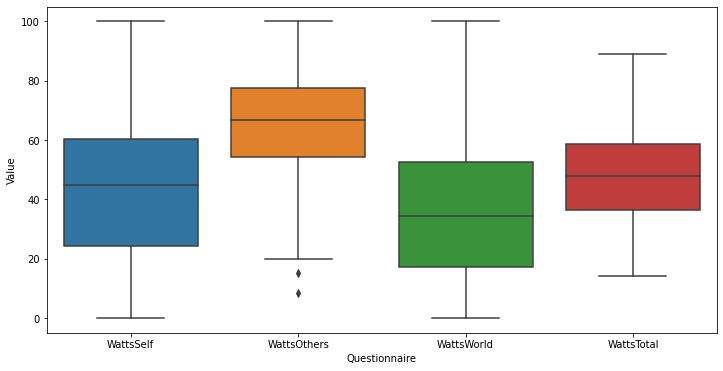

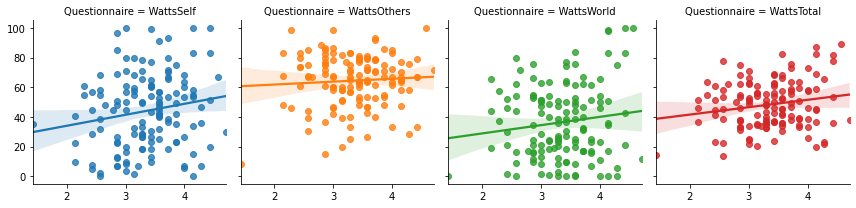

In [52]:
plt.rcParams['figure.figsize'] = 12, 6
player_plots(player_df)

We study the questionnaire responses by whether the group emerged or not, excluding the players with `manual=1`.

In [53]:
def group_plots(data, cols_to_drop, var_name, hue, title):

    gmelt = data.drop(cols_to_drop, axis=1).melt(id_vars = ['Group', hue ],
                      var_name = var_name, value_name = 'Value')
    
    sns.boxplot(data = gmelt, x = var_name, y='Value', hue = hue)
    plt.title(title)
    plt.show()
    sns.violinplot(data = gmelt, x = var_name, y ='Value', hue = hue) #,split = True
    plt.title(title)
    plt.show()

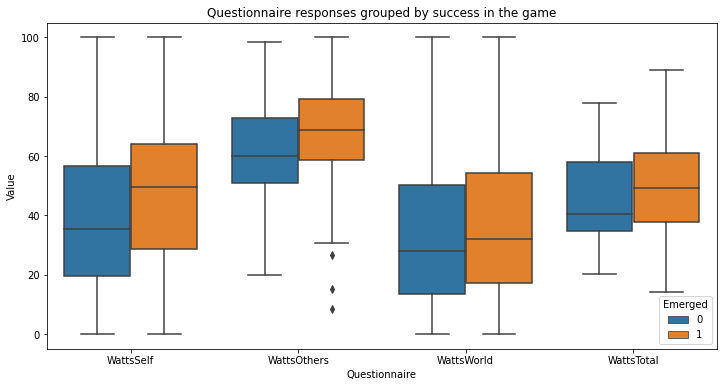

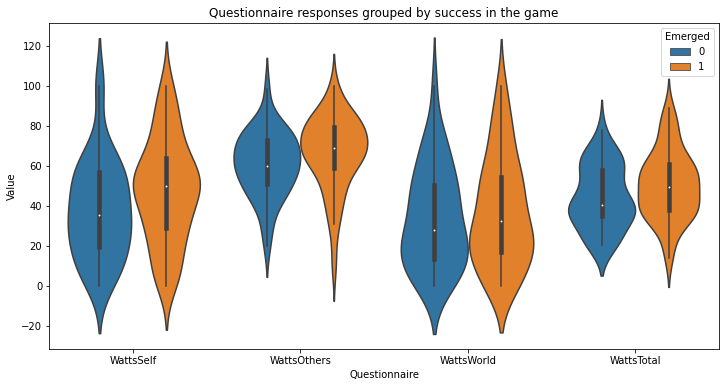

In [54]:
plt.rcParams['figure.figsize'] = 12, 6
group_plots(df_player[df_player['Manual'] == 0].drop('Manual', axis = 1), 
            ['Duration', 'DavisPerspective', 'Outcome' ],
            'Questionnaire', 'Emerged', 'Questionnaire responses grouped by success in the game')

We study the questionnaire responses by the group outcome.

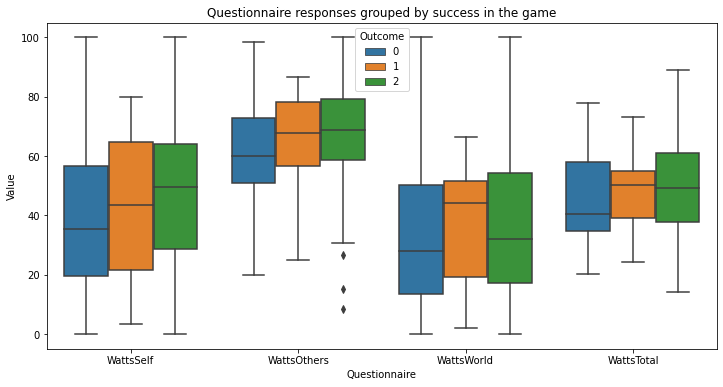

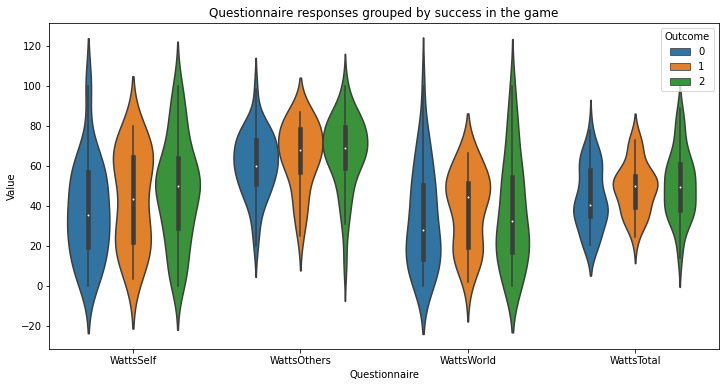

In [55]:
plt.rcParams['figure.figsize'] = 12, 6
group_plots(df_player, 
            ['Duration', 'DavisPerspective', 'Emerged', 'Manual' ],
            'Questionnaire', 'Outcome', 'Questionnaire responses grouped by success in the game')